###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

In [1]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

# 粘弹性应力-应变关系

我们比较了在频域不同的粘弹性应力-应变关系来实现常 Q(ω) 的行为。

## 一维各向同性SH问题: 线弹性 vs. 粘弹性介质

为了理解线弹性和粘弹性一维SH问题的区别，我们首先回顾了一维弹性SH问题的偏微分方程。这包括动量守恒:

\begin{equation}
\rho \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial \sigma_{yx}}{\partial x} + f_y\notag
\end{equation}

描述介质内变形 $\epsilon_{yx}$ 作为给定剪应力 $\sigma_{yx}$ 的响应, 我们使用线性应力-应变关系:


\begin{equation}
\sigma_{yx} = 2\mu \epsilon_{yx}\notag
\end{equation}

通过剪切模量 $\mu$. 为了简化符号，我定义 

\begin{equation}
\mu' = 2\mu\notag
\end{equation}

和 

\begin{equation}
\mu = \mu'\notag
\end{equation}

进一步, 我代替:

\begin{align}
\sigma_{yx} &\rightarrow \sigma\notag\\
\epsilon_{yx} &\rightarrow \epsilon\notag\\
\end{align}

得到:

\begin{equation}
\sigma = \mu \epsilon\notag
\end{equation}

为了描述一个 **线性粘弹性介质**, 我们只需要修改应力应变关系，因为动量守恒与材料行为无关。粘弹性应力-应变关系可以被描述为 **玻尔兹曼叠加和因果原理**:

\begin{equation}
\sigma = \int_{-\infty}^{t}\Psi(t-t')\dot{\epsilon}(t')dt'\notag
\end{equation}

通过 **松弛函数 $\Psi$**。松弛函数和积分边界构成了因果关系。你可以看到粘弹性介质有一个包含应变率历史的“褪色”记忆。根据定义，我们可以将应力-应变关系重写为松弛函数与应变速率 $\dot{\epsilon}$ 的卷积：

\begin{equation}
\sigma = \Psi*\dot{\epsilon}\notag
\end{equation}

利用卷积时间导数的性质:

\begin{equation}
\frac{\partial}{\partial t} (\Psi*\epsilon) = \frac{\partial \Psi}{\partial t} * \epsilon = \Psi * \frac{\partial \epsilon}{\partial t}\notag
\end{equation}

我们可以把粘弹性介质的应力应变关系改写为

\begin{equation}
\sigma = \dot{\Psi}*\epsilon\notag
\end{equation}

让我们比较弹性介质和粘弹性介质的应力-应变关系，假设应力和应变谐变。 

在弹性情况下，这两个变化是一致的:

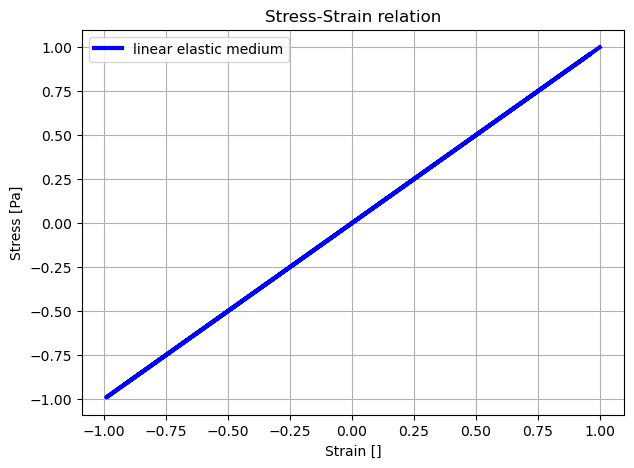

In [2]:
# Stress-stain relation for linear elastic medium
# -----------------------------------------------
t = np.arange(0.0,10.0)  # time (s)

sigma0 = 1.0             # maximum stress (Pa)
epsilon0 = 1.0           # maximum strain ()
omega = 1.0              # Circular frequency (rad/s)

# Calculate temporal changes of sigma and epsilon
# -----------------------------------------------
sigma = sigma0 * np.cos(omega*t)
epsilon = epsilon0 * np.cos(omega*t)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(epsilon, sigma, 'b-',lw=3,label="linear elastic medium")
plt.title('Stress-Strain relation')
plt.xlabel('Strain []')
plt.ylabel('Stress [Pa]')
plt.legend()
plt.grid()
plt.show()

在粘弹性的情况下，应力和应变是不相的。我们稍后会看到，相移 $\phi$ 是与品质因子 $Q$ 相关的 

\begin{equation}
\phi = \arctan{\frac{1}{Q}} \notag
\end{equation}

这就引出了粘弹性应力应变关系:

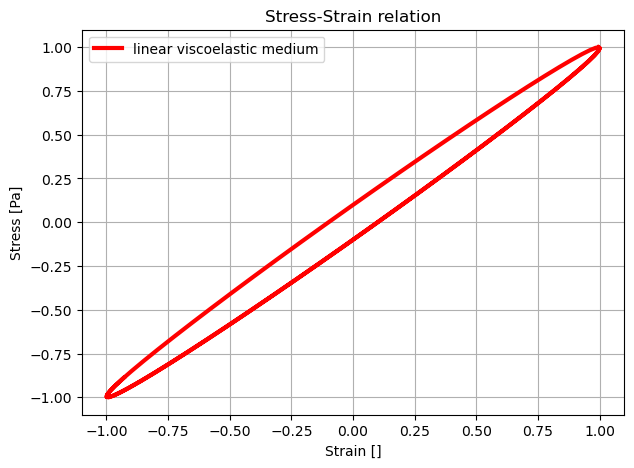

In [3]:
# Stress-stain relation for linear viscoelastic medium
# ----------------------------------------------------
t = np.arange(0.0,10.0,0.1)  # time (s)

sigma0 = 1.0             # maximum stress (Pa)
epsilon0 = 1.0           # maximum strain ()
omega = 1.0              # Circular frequency (rad/s)

# define phase shift of strain
Q = 10                     # quality factor ()
phi = np.arctan(1/Q)       # phase shift (rad)

# Calculate temporal changes of sigma and epsilon
# -----------------------------------------------
sigma = sigma0 * np.cos(omega*t)
epsilon = epsilon0 * np.cos(omega*t - phi)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(epsilon, sigma, 'r-',lw=3,label="linear viscoelastic medium") 
plt.title('Stress-Strain relation')
plt.xlabel('Strain []')
plt.ylabel('Stress [Pa]')
plt.legend()
plt.grid()
plt.show()

能量损失 $\Delta E$ ，例如热量损失, 它由 [hysteresis loop](https://en.wikipedia.org/wiki/Hysteresis)内的面积定义, 因此我们计算 $\Delta E$ 通过:

\begin{equation}
\Delta E = \oint \sigma(\epsilon') d\epsilon' \notag
\end{equation}

此外，我们还可以区分线性粘弹性的两种特殊情况:

1. 上述情况是 **不可逆(非弹性)**
2. **可逆(非弹性)** 介质在去除负载后可以恢复到原来的状态

## 粘弹性模型

到目前为止，松弛函数的细节还没有定义。因此，下一步是寻找一个 $Q(\omega)$-value 与频率无关的松弛函数。与电网络类似，我们可以构建由两个基本元素组成的粘弹性模型。

### 基本元素

这些基本元素为 

<img src="images/Hooke_Newton_model.png" width="60%">

* The **Hooke element** (spring), 表示线弹性介质

\begin{align}
\sigma_{Hooke} &= \mu \epsilon \notag\\
&\text{or} \notag\\
\epsilon_{Hooke} &= \frac{\sigma}{\mu}\notag\\
\end{align}

* The **Newton element** (dashpot), 代表用应力-应变关系表示的粘性阻尼部分: 

\begin{align}
\sigma_{Newton} &= \eta \dot{\epsilon} \notag\\
&\text{or} \notag\\
\dot{\epsilon}_{Newton} &= \frac{\sigma}{\eta}\notag\\
\end{align}

这里 $\eta$ 代表介质的粘度。

### Maxwell模型

为了实现不同的粘弹性介质，可以将不同网络中的基本元素组合起来。胡克与牛顿单元的串连得到 **麦克斯韦模型**:

<img src="images/Maxwell_model.png" width="70%">

在串行连接中，有效变形可以用基本单元变形之和来计算

\begin{equation}
\epsilon = \epsilon_1 + \epsilon_2 \notag
\end{equation}

或者通过对时间求导

\begin{equation}
\dot{\epsilon} = \dot{\epsilon}_1 + \dot{\epsilon}_2 \notag
\end{equation}

For the Maxwell-model we get the following ordinary differential equation for $\epsilon$ and $\sigma$

\begin{equation}
\dot{\epsilon}_{M} = \dot{\epsilon}_{Newton} + \dot{\epsilon}_{Hooke} = \frac{\sigma}{\eta} + \frac{\dot{\sigma}}{\mu}\notag
\end{equation}

We solve this problem by Fourier transform, where the wavefields in the frequency domain are defined as  

\begin{equation}
\tilde{f}(\omega) = \int_{-\infty}^{\infty} f(t) exp(-i\omega t) dt\notag
\end{equation}

Time-derivatives are transformed according to:

\begin{equation}
i \omega \tilde{f}(\omega) = \int_{-\infty}^{\infty} \dot{f}(t) exp(-i\omega t) dt\notag
\end{equation}

Therefore, the Maxwell-model in the frequency domain is:

\begin{equation}
i \omega \tilde{\epsilon}_{M} = \frac{\tilde{\sigma}}{\eta} + \frac{i \omega \tilde{\sigma}}{\mu}\notag
\end{equation}

After some rearrangements, we get the stress-strain relation in the frequency domain

\begin{equation}
\tilde{\epsilon}_{M} = \biggl(\frac{1}{\mu}+\frac{1}{i \omega \eta}\biggr) \tilde{\sigma}\notag
\end{equation}

where we can connect strain with stress via a complex shear modulus $\tilde{\mu}_M$:

\begin{equation}
\tilde{\epsilon}_{M} = \tilde{\mu_M} \tilde{\sigma}\notag
\end{equation}

with 

\begin{equation}
\tilde{\mu}_M = \frac{1}{\mu}+\frac{1}{i \omega \eta}\notag
\end{equation}

For the application in seismic modelling, it is important that the visco-elastic model can describe a frequency-independent $Q(\omega)$. This question can be quite easily answered, because we can connect the real and imaginary parts of the complex shear modulus $\tilde{\mu}_M$ for the Maxwell-model with the quality factor $Q$ by:

\begin{equation}
\frac{1}{Q} = \frac{{\frak{I}}\{\tilde{\mu}_M\}}{{\frak{R}}\{\tilde{\mu}_M\}} = \tan{\phi},\notag
\end{equation}

which also explains why we could relate the phase angle $\phi$ with $1/Q$, when we investigated the stress-strain relations for harmonic stress/strain above. So let's plot $1/Q$ as a function of $\omega$:

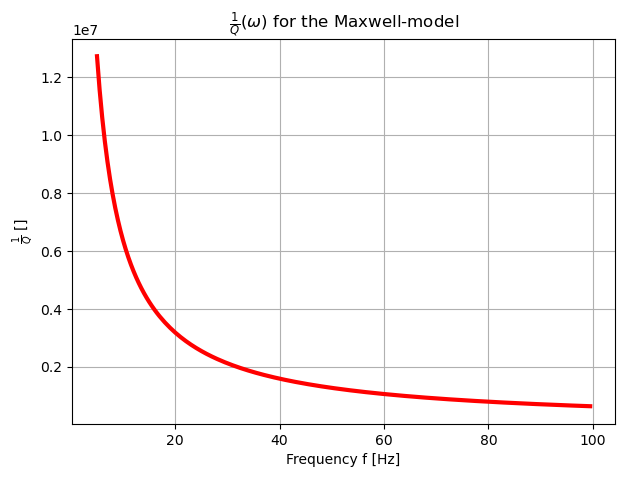

In [4]:
# 1/Q(omega) for the Maxwell-model
# --------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
eta = 1.0            # viscosity (Pa s)

# Define complex shear modulus for Maxwell-model
# ----------------------------------------------
muM = (1/mu) + (1/(1j*omega*eta))

# Calculate 1/Q(omega)
# --------------------
Qinv = np.abs(np.imag(muM)/np.real(muM))

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Maxwell-model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for the Maxwell-model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

As you can see, the Maxwell-model is not useful to model viscoelastic seismic wave propagation, because we have small damping at high frequencies.

### Kelvin–Voigt model

What happens if we connect the Hooke and Newton elements leading to the **Kelvin-Voigt model**?

<img src="images/Kelvin_Voigt_model.png" width="70%">

In a parallel connection of elements, the effective stress can be calculated by the sum of the basic element stresses

\begin{equation}
\sigma = \sigma_1 + \sigma_2 \notag
\end{equation}

For the Maxwell-model we have the stresses

\begin{align}
\sigma_{Hooke} &= \mu \epsilon\notag \\
\sigma_{Newton} &= \eta \dot{\epsilon}\notag \\
\end{align}

which yields the ordinary differential equation for the Kelvin-Voigt model

\begin{equation}
\sigma_{KV} = \sigma_{Hooke} + \sigma_{Newton} = \mu \epsilon + \eta \dot{\epsilon} \notag
\end{equation}

After Fourier transform and some rearrangement we get

\begin{equation}
\tilde{\sigma}_{KV}(\omega) = (\mu + \eta i \omega)\; \tilde{\epsilon}(\omega) \notag
\end{equation}

where the complex shear modulus for the Kelvin-Voigt model

\begin{equation}
\tilde{\mu}_{KV} = (\mu + \eta i \omega) \notag
\end{equation}

can be identified. Let's calculate the $1/Q(\omega)$ behavior from real and imaginary part of the complex Kelvin-Voigt shear modulus:

In [ ]:
# 1/Q(omega) for the Kelvin-Voigt model
# -------------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
eta = 1.0            # viscosity (Pa s)

# Define complex shear modulus for Kelvin-Voigt model
# ---------------------------------------------------
muKV = mu + 1j * omega * eta

# Calculate 1/Q(omega)
# --------------------
Qinv = np.imag(muKV)/np.real(muKV)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Kelvin-Voigt model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for the Kelvin-Voigt model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

Unfortunately, the Kelvin-Voigt model is also not suitable to model viscoelastic wave propagation, because the damping increases linear with frequency.


### Standard Linear Solid (SLS) - Maxwell

Another idea to construct a viscoelastic model is to combine the Maxwell element with a Hooke element in parallel. This is denoted as **Standard Linear Solid (SLS) in Maxwell representation**

<img src="images/SLS.png" width="70%">

Because we have to combine elements in parallel, the stresses of components have to be added:

\begin{equation}
\sigma_{SLSM} = \sigma_{Hooke} + \sigma_{Maxwell} \notag
\end{equation}

For simplicity we will do this directly in the frequency domain:

\begin{equation}
\tilde{\sigma}_{SLSM} = \tilde{\sigma}_{Hooke} + \tilde{\sigma}_{Maxwell} \notag
\end{equation}

Inserting the stresses

\begin{align}
\tilde{\sigma}_{Hooke} &= \mu_0 \tilde{\epsilon}\notag \\
\tilde{\sigma}_{Maxwell} &= \frac{i \mu_1 \omega \eta}{i \omega \eta + \mu_1} \tilde{\epsilon}\notag \\
\end{align}

yields the frequency-domain stress-strain relation for the SLS in Maxwell representation:

\begin{equation}
\tilde{\sigma}_{SLSM} = \biggl(\mu_0 + \frac{i \mu_1 \omega \eta}{i \omega \eta + \mu_1}\biggr) \tilde{\epsilon} \notag
\end{equation}

The complex SLS shear modulus $\tilde{\mu}_{SLSM}$ can be rewritten as

\begin{equation}
\tilde{\mu}_{SLSM} = \mu_0 + \frac{i \mu_1 \omega}{i \omega + \frac{\mu_1}{\eta}} \notag
\end{equation}

Notice that the quantity $\frac{\mu_1}{\eta}$ has the dimension $\left[\frac{Pa}{Pa\; s}\right] = \left[\frac{1}{s}\right]$ of a frequency. A more detailed analysis reveals that this is the **relaxation frequency**

\begin{equation}
\omega_1 :=\frac{\mu_1}{\eta} \notag
\end{equation}

Therefore, we get:

\begin{equation}
\tilde{\mu}_{SLSM} = \mu_0 + \frac{i \mu_1 \omega}{i \omega + \omega_1} \notag
\end{equation}

How does the $1/Q(\omega)$ frequency spectrum look like?

In [ ]:
# 1/Q(omega) for the Maxwell SLS
# ------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu0 = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
mu1 = 1               # shear modulus (Pa)

f1 = 50.0
omega1 = 2 * np.pi * f1

# Define complex shear modulus for Kelvin-Voigt model
# ---------------------------------------------------
muSLSM = mu0 + (1j * mu1 * omega)/((1j * omega) + omega1)

# Calculate 1/Q(omega)
# --------------------
Qinv = np.imag(muSLSM)/np.real(muSLSM)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Maxwell SLS model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for Maxwell SLS model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

This result looks promising. While $1/Q$ is not frequency independent, we see for the Maxwell SLS model a peak at a given frequency and decreases at lower and higher frequencies. For completeness, I note that we could also build a **Kelvin-Voigt SLS model** by connecting a Hooke element with a Kelvin-Voigt element in parallel. However, in the following we will further focus on the potential of the Maxwell SLS model.

## Generalized Maxwell-model

Based on the promising results of the Maxwell SLS model, we add multiple Maxwell models in parallel, which yields the **Generalized Maxwell model or Generalized Maxwell body (GMB)**, also known as **Maxwell-Wiechert model**. By the superposition of multiple Maxwell models with different elastic modules $\mu_l$ and viscosities $\eta_l$, we can achieve a constant Q-value over a given frequency range.

<img src="images/GMB.png" width="70%">

Because we assemble the Maxwell SLS model with additional L Maxwell bodies in parallel, we have to add the stresses in frequency domain:

\begin{equation}
\tilde{\sigma}_{GMB} = \tilde{\sigma}_{SLSM} + \sum_{l=2}^{L} \tilde{\sigma}_{Maxwell, l} \notag
\end{equation}

Inserting the stresses

\begin{align}
\tilde{\sigma}_{SLSM} &= \biggl(\mu_0 + \frac{i \mu_1 \omega \eta_1}{i \omega \eta_1 + \mu_1}\biggr) \tilde{\epsilon} \notag \\
\tilde{\sigma}_{Maxwell, l} &= \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l} \tilde{\epsilon}\notag \\
\end{align}

yields the frequency-domain stress-strain relation for the GMB

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \frac{i \mu_1 \omega \eta_1}{i \omega \eta_1 + \mu_1} + \sum_{l=2}^{L} \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

We can move the second term into the sum over the L Maxwell-models:

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

Introducing the **relaxation frequencies** 

\begin{equation}
\omega_l :=\frac{\mu_1}{\eta_l} \notag
\end{equation}

leads to

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega}{i \omega + \omega_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

I want to simplify the complex modulus 

\begin{equation}
\tilde{\mu}_{GMB} = \mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega}{i \omega + \omega_l}. \notag
\end{equation}

First we estimate the relaxed shear modulus:

\begin{equation}
\tilde{\mu}_{GMB,R} = \lim_{\omega\rightarrow 0} \tilde{\mu}_{GMB} = \mu_0\notag
\end{equation}

and unrelaxed shear modulus:

\begin{equation}
\tilde{\mu}_{GMB,U} = \lim_{\omega\rightarrow \infty} \tilde{\mu}_{GMB} = \mu_0 + \sum_{l=1}^{L} \mu_l\notag
\end{equation}

With the **modulus defect** or **relaxation of modulus** 

\begin{equation}
\delta \mu = \tilde{\mu}_{GMB,U} - \tilde{\mu}_{GMB,R} = \sum_{l=1}^{L} \mu_l\notag
\end{equation}

we get

\begin{equation}
\delta \mu_l = \mu_l\notag
\end{equation}

Without any simplification we can consider

\begin{equation}
\delta \mu_l = a_l \delta \mu\notag
\end{equation}

with the normalization

\begin{equation}
\sum_{l=1}^L a_l = 1\notag
\end{equation}

This yields 

\begin{equation}
\tilde{\mu}_{GMB} = \mu_0 + \delta \mu \sum_{l=1}^{L} \frac{i a_l \omega}{i \omega + \omega_l}. \notag
\end{equation}

Let's try to approximate a constant $Q(\omega) = 10$ model for frequencies between 5 and 100 Hz by using 4 Maxwell bodies and setting all shear moduli of the Maxwell bodies to a constant value.

In [ ]:
# Q(omega) for the GMB with 4 Maxwell bodies
# --------------------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
nf = len(f)
omega = 2 * np.pi * f

# relaxation frequencies
L = 4   # number of Maxwell bodies
fl = np.linspace(5.0,100.0,L)
omegal = 2. * np.pi * fl

# Define relaxed shear modulus and defect for GMB
mu0 = 4e8          # shear modulus (Pa) for soil from Dokter et al. (2017)
dmu = 1.4e8        # shear moduli of Maxwell bodies (Pa)

# Simply set a_l = 1.0 / L
a_l = 1.0 / L 

# Define complex shear modulus for GMB model
# ------------------------------------------
muM = np.zeros(nf,dtype='complex128')
for l in range(0,L):
    muM += (1j * a_l * omega)/((1j * omega) + omegal[l])
muGMB = mu0 + dmu * muM

# Calculate Q(omega)
# --------------------
Q = np.real(muGMB)/np.imag(muGMB)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Q, 'r-',lw=3,label="General Maxwell model") 
plt.title(r'$Q(\omega)$ for General Maxwell model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$Q$ []')
plt.ylim(0,20)
plt.grid()
plt.show()

While the result is not perfect, we could get an approximately constant $Q(\omega)=10$  value for frequencies between 5 and 100 Hz. We will optimize this result in the next lesson.

## What we learned:

- The viscoelastic stress-strain relation can be described by a time convolution of a relaxation function with the strain rate. The relaxation function together with the integral bounds impose a causality and "fading" memory of the viscoelastic medium
- A low Q-model introduces a phase shift in the stress-strain relation. The area between the hysteresis loop defines the energy loss
- By assembling multiple basic Hooke and Newton elements in a serial and/or parallel network, we can derive a complex shear modulus in the frequency domain and achieve a constant $Q(\omega)$ behavior